# Matching

In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions and Maps

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None


def duplicate_cleaner(ids, truth):
    reshaped_ids = ak.unflatten(ak.ravel(ak.Array(ids['id'])),ak.num(ak.Array(ids['id'])))
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(reshaped_ids)])
    has_repeats = ak.num(deduped_id_pairs) != ak.num(reshaped_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(reshaped_ids) - 1
    more_repeats = ak.num(deduped_id_pairs) < (ak.num(reshaped_ids) - 1)

    duplicate_truth_1 = truth[one_repeat]
    duplicate_ids_1 = ids[one_repeat]

    more_duplicate_truth = truth[more_repeats]
    more_duplicate_ids = ids[more_repeats]

    id_pairs = ids[~has_repeats]
    return id_pairs, (duplicate_truth_1, duplicate_ids_1), (more_duplicate_truth, more_duplicate_ids)

j = 0
def duplicate_matcher(id_pairs, truth, i):
    repeat_ids = ak.unflatten(ak.ravel(ak.Array(id_pairs['id'])),ak.num(ak.Array(id_pairs['id'])))
    repeat_i = ak.num(repeat_ids[repeat_ids==i], axis=1)==2

    truth_i = truth[repeat_i]
    id_pairs_i = id_pairs[repeat_i]

    valid_id_particles = id_pairs_i[id_pairs_i['id']!=i]
    valid_id_particles = valid_id_particles[ak.num(valid_id_particles, axis=2)!=0]

    repeat_recos = id_pairs_i[id_pairs_i['id']==i]
    repeat_recos = repeat_recos[ak.num(repeat_recos, axis=2)!=0]

    duplicate_deltars = ak.unflatten(ak.ravel(repeat_recos['reco'].deltaR(truth_i[:,i-1])),2)
    min_dupdeltars = ak.unflatten(ak.min(duplicate_deltars, axis=1),1)

    matched_recos = repeat_recos[duplicate_deltars==min_dupdeltars]
    unmatched_recos = ak.unflatten(ak.ravel(repeat_recos['reco'][duplicate_deltars!=min_dupdeltars]),1)

    valid_id_particles = ak.concatenate((valid_id_particles, matched_recos), axis=1)
    possible_truth = ak.concatenate((truth_i[:,0:i-1],truth_i[:,i:len(truth[0])]), axis=1)

    id = np.tile(np.hstack((np.arange(1,i),np.arange(i+1,len(possible_truth[0])+2))), (len(possible_truth),1))
    pairs_2d = ak.cartesian({'reco':unmatched_recos,'truth':possible_truth})
    id_pairs_2d = ak.cartesian({'reco':unmatched_recos,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(possible_truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(possible_truth[0]), axis=1)

    deltars = ak.unflatten(ak.ravel(pairs_3d['reco'].deltaR(pairs_3d['truth'])),len(truth[0])-1)
    min_deltars = ak.unflatten(np.min(deltars, axis=1),1)

    id_pairs_3d = id_pairs_3d[ak.unflatten(deltars == min_deltars,1)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]
    add_match = valid_id_particles[ak.num(id_pairs_3d)!=0]

    valid_id_events = valid_id_particles[ak.num(id_pairs_3d)==0]
    pairs_to_concatenate = [valid_id_events]

    id_pairs_3d = id_pairs_3d[ak.num(id_pairs_3d)!=0]
    additional_matches = ak.concatenate((id_pairs_3d, add_match), axis=1)

    reshaped_ids = ak.unflatten(ak.ravel(ak.Array(additional_matches['id'])),ak.num(ak.Array(additional_matches['id'])))
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(reshaped_ids)])
    if len(reshaped_ids) != 0:
        has_repeats = ak.num(deduped_id_pairs) != ak.num(reshaped_ids)
        pairs_to_concatenate.append(id_pairs_3d[has_repeats])
        pairs_to_concatenate.append(additional_matches[~has_repeats])
        print(len(id_pairs_3d[has_repeats]))
    else:
        pairs_to_concatenate.append(id_pairs_3d)
    
    clean_id_pairs = ak.concatenate(pairs_to_concatenate)
    repeat_ids = ak.unflatten(ak.ravel(id_pairs['id']),ak.num(id_pairs['id']))
    return clean_id_pairs


def truth_matching(reco, truth):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    pairs_2d = ak.cartesian({'reco':reco,'truth':truth})
    id_pairs_2d = ak.cartesian({'reco':reco,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(truth[0]), axis=1)

    deltars = pairs_3d['reco'].deltaR(pairs_3d['truth'])
    min_deltars = np.min(deltars, axis=2)
    id_pairs_3d = id_pairs_3d[(deltars == min_deltars)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]

    id_pairs_3d, (duplicate_truths, duplicate_id_pairs), (more_duplicate_truth, more_duplicate_ids)  = duplicate_cleaner(id_pairs_3d, truth)
    print(len(id_pairs_3d), len(duplicate_truths))
    clean_events = [id_pairs_3d]
    i_range = np.arange(1,len(truth[0])+1)
    for i in i_range:
        clean_events.append(duplicate_matcher(duplicate_id_pairs, duplicate_truths, i))
    clean_events = ak.concatenate(clean_events)
    print(len(clean_events))
    
    return clean_events


mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

## Data

### 4 Top Matching

In [3]:
tree4 = uproot.open(directory + "4tops_withtruth_oct24.root")
events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_4t_neutrinos = tree4["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_4t_truth = tree4['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_4t_truth = events_4t_truth[(events_4t_truth['Particle.Status']==23)]

events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 105.7E-3

jets_pt_4t = events_4t_jets['Jet.PT'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_eta_4t = events_4t_jets['Jet.Eta'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_phi_4t = events_4t_jets['Jet.Phi'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_mass_4t = events_4t_jets['Jet.Mass'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]

electrons_pt_4t = events_4t_electrons['Electron.PT'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_eta_4t = events_4t_electrons['Electron.Eta'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_phi_4t = events_4t_electrons['Electron.Phi'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_mass_4t = events_4t_electrons['Electron.Mass'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]

muons_pt_4t = events_4t_muons['Muon.PT'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_eta_4t = events_4t_muons['Muon.Eta'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_phi_4t = events_4t_muons['Muon.Phi'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_mass_4t = events_4t_muons['Muon.Mass'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]

reco_pt_4t = ak.concatenate((jets_pt_4t,electrons_pt_4t,muons_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jets_eta_4t,electrons_eta_4t,muons_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jets_phi_4t,electrons_phi_4t,muons_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jets_mass_4t,electrons_mass_4t,muons_mass_4t), axis=1)

truth_pt_4t = events_4t_truth['Particle.PT']
truth_eta_4t = events_4t_truth['Particle.Eta']
truth_phi_4t = events_4t_truth['Particle.Phi']
truth_mass_4t = events_4t_truth['Particle.Mass']

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

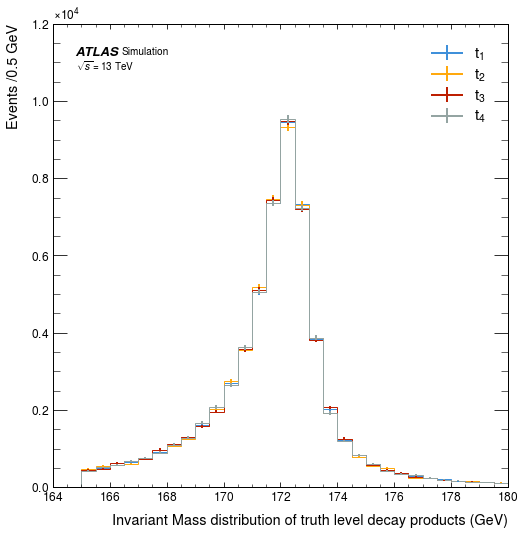

In [4]:
reco_4t_test = reco_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]
truth_4t_test = truth_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]

truth_4t_12 = truth_4t[ak.num(truth_4t)==12]
reco_4t_12 = reco_4t[ak.num(truth_4t)==12]

truth_4t_13 = truth_4t[ak.num(truth_4t)==13]
truth_4t_13 = truth_4t_13[:,1:]
reco_4t_13 = reco_4t[ak.num(truth_4t)==13]

truth_4t_test = ak.concatenate((truth_4t_12, truth_4t_13))
reco_4t_test = ak.concatenate((reco_4t_12, reco_4t_13))

t1 = truth_4t_test[:,0]+truth_4t_test[:,4]+truth_4t_test[:,5]
t2 = truth_4t_test[:,1]+truth_4t_test[:,6]+truth_4t_test[:,7]
t3 = truth_4t_test[:,2]+truth_4t_test[:,8]+truth_4t_test[:,9]
t4 = truth_4t_test[:,3]+truth_4t_test[:,10]+truth_4t_test[:,11]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m, t4.m], 30, [r't$_1$', r't$_2$', r't$_3$', r't$_4$'], ax, density = False, x_units='GeV', set_range=(165,180))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

In [5]:
id_pairs_4t = truth_matching(reco_4t_test, truth_4t_test)

top_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==1)|(id_pairs_4t['id']==5)|(id_pairs_4t['id']==6)]
top_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==2)|(id_pairs_4t['id']==7)|(id_pairs_4t['id']==8)]
antitop_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==3)|(id_pairs_4t['id']==9)|(id_pairs_4t['id']==10)]
antitop_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==4)|(id_pairs_4t['id']==11)|(id_pairs_4t['id']==12)]

top_1_particles_4t_temp = top_1_particles_4t[(ak.num(top_1_particles_4t, axis=2)!=0)]
top_2_particles_4t_temp = top_2_particles_4t[(ak.num(top_2_particles_4t, axis=2)!=0)]
antitop_1_particles_4t_temp = antitop_1_particles_4t[(ak.num(antitop_1_particles_4t, axis=2)!=0)]
antitop_2_particles_4t_temp = antitop_2_particles_4t[(ak.num(antitop_2_particles_4t, axis=2)!=0)]

top_1_particles_4t = top_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
top_2_particles_4t = top_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_1_particles_4t = antitop_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_2_particles_4t = antitop_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]

top_1_4t = ak.flatten(np.sum(top_1_particles_4t, axis=1))
top_2_4t = ak.flatten(np.sum(top_2_particles_4t, axis=1))
antitop_1_4t = ak.flatten(np.sum(antitop_1_particles_4t, axis=1))
antitop_2_4t = ak.flatten(np.sum(antitop_2_particles_4t, axis=1))

57072 4393
2
3
4
5
6
4
4
5
1
4
3
2
61465


Peak bin center for top 1: 6.75 GeV
Peak bin center for top 2: 6.75 GeV
Peak bin center for antitop 1: 7.25 GeV
Peak bin center for antitop 2: 6.25 GeV


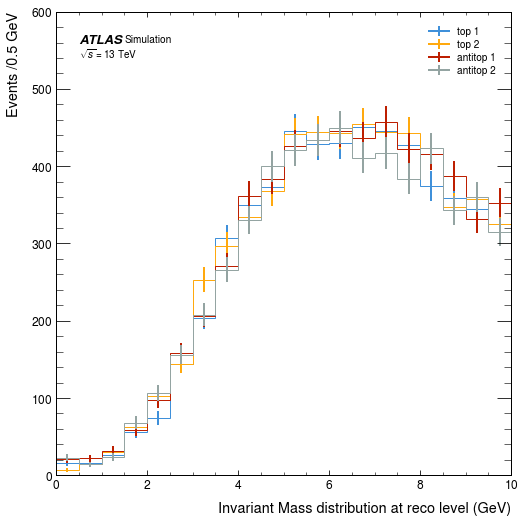

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_4t.m, top_2_4t.m, antitop_1_4t.m, antitop_2_4t.m], 20, ['top 1','top 2','antitop 1','antitop 2'], ax, density = False, x_units='GeV', set_range=(0,10), print_peak=True)
ax.set_xlabel(r'Invariant Mass distribution at reco level (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

### 3 Top Matching

['Event', 'Event/Event.fUniqueID', 'Event/Event.fBits', 'Event/Event.Number', 'Event/Event.ReadTime', 'Event/Event.ProcTime', 'Event/Event.ProcessID', 'Event/Event.MPI', 'Event/Event.Weight', 'Event/Event.CrossSection', 'Event/Event.CrossSectionError', 'Event/Event.Scale', 'Event/Event.AlphaQED', 'Event/Event.AlphaQCD', 'Event/Event.ID1', 'Event/Event.ID2', 'Event/Event.X1', 'Event/Event.X2', 'Event/Event.ScalePDF', 'Event/Event.PDF1', 'Event/Event.PDF2', 'Particle', 'Particle/Particle.fUniqueID', 'Particle/Particle.fBits', 'Particle/Particle.PID', 'Particle/Particle.Status', 'Particle/Particle.IsPU', 'Particle/Particle.M1', 'Particle/Particle.M2', 'Particle/Particle.D1', 'Particle/Particle.D2', 'Particle/Particle.Charge', 'Particle/Particle.Mass', 'Particle/Particle.E', 'Particle/Particle.Px', 'Particle/Particle.Py', 'Particle/Particle.Pz', 'Particle/Particle.P', 'Particle/Particle.PT', 'Particle/Particle.Eta', 'Particle/Particle.Phi', 'Particle/Particle.Rapidity', 'Particle/Particle.T', 'Particle/Particle.X', 'Particle/Particle.Y', 'Particle/Particle.Z', 'Jet', 'Jet/Jet.fUniqueID', 'Jet/Jet.fBits', 'Jet/Jet.T',', 'Jet/Jet.DeltaEta', 'Jet/Jet.DeltaPhi', 'Jet/Jet.Flavor', 'Jet/Jet.FlavorAlgo', 'Jet/Jet.FlavorPhys', 'Jet/Jet.BTagAlgo', 'Jet/Jet.BTagPhys', 'Jet/Jet.TauTag', 'Jet/Jet.TauWeight', 'Jet/Jet.Charge', 'Jet/Jet.EhadOverEem', 'Jet/Jet.NCharged', 'Jet/Jet.NNeutrals', 'Jet/Jet.NeutralEnergyFraction', 'Jet/Jet.ChargedEnergyFraction', 'Jet/Jet.Beta', 'Jet/Jet.BetaStar', 'Jet/Jet.MeanSqDeltaR', 'Jet/Jet.PTD', 'Jet/Jet.SoftDroppedJet', 'Jet/Jet.SoftDroppedSubJet1', 'Jet/Jet.SoftDroppedSubJet2', 'Jet/Jet.NSubJetsTrimmed', 'Jet/Jet.NSubJetsPruned', 'Jet/Jet.NSubJetsSoftDropped', 'Jet/Jet.ExclYmerge23', 'Jet/Jet.ExclYmerge34', 'Jet/Jet.ExclYmerge45', 'Jet/Jet.ExclYmerge56', 'Jet/Jet.Constituents', 'Jet/Jet.Particles', 'Jet/Jet.Area', 'Electron', 'Electron/Electron.fUniqueID', 'Electron/Electron.fBits', 'Electron/Electron.T', 'Electron/Electron.Charge', 'Electron/Electron.EhadOverEem', 'Electron/Electron.Particle', 'Electron/Electron.IsolationVar', 'Electron/Electron.IsolationVarRhoCorr', 'Electron/Electron.SumPtCharged', 'Electron/Electron.SumPtNeutral', 'Electron/Electron.SumPtChargedPU', 'Electron/Electron.SumPt', 'Electron/Electron.D0', 'Electron/Electron.DZ', 'Electron/Electron.ErrorD0', 'Electron/Electron.ErrorDZ', 'Muon', 'Muon/Muon.fUniqueID', 'Muon/Muon.fBits', 'Muon/Muon.T', 'Muon/Muon.Charge', 'Muon/Muon.Particle', 'Muon/Muon.IsolationVar', 'Muon/Muon.IsolationVarRhoCorr', 'Muon/Muon.SumPtCharged', 'Muon/Muon.SumPtNeutral', 'Muon/Muon.SumPtChargedPU', 'Muon/Muon.SumPt', 'Muon/Muon.D0', 'Muon/Muon.DZ', 'Muon/Muon.ErrorD0', 'Muon/Muon.ErrorDZ', 'MissingET', 'MissingET/MissingET.fUniqueID', 'MissingET/MissingET.fBits']


In [7]:
tree3j = uproot.open(directory + "tttj_skimmed_2810_withtruth_0.root")
events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tj_neutrinos = tree3j["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tj_truth = tree3j['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tj_truth = events_3tj_truth[(events_3tj_truth['Particle.Status']==23)]

events_3tj_electrons['Electron.Mass'] = np.ones_like(events_3tj_electrons['Electron.PT']) * 0.511E-3
events_3tj_muons['Muon.Mass'] = np.ones_like(events_3tj_muons['Muon.PT']) * 105.7E-3

jets_pt_3tj = events_3tj_jets['Jet.PT'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_eta_3tj = events_3tj_jets['Jet.Eta'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_phi_3tj = events_3tj_jets['Jet.Phi'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_mass_3tj = events_3tj_jets['Jet.Mass'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]

electrons_pt_3tj = events_3tj_electrons['Electron.PT'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tj = events_3tj_electrons['Electron.Eta'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tj = events_3tj_electrons['Electron.Phi'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tj = events_3tj_electrons['Electron.Mass'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tj = events_3tj_muons['Muon.PT'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_eta_3tj = events_3tj_muons['Muon.Eta'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_phi_3tj = events_3tj_muons['Muon.Phi'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_mass_3tj = events_3tj_muons['Muon.Mass'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]

reco_pt_3tj = ak.concatenate((jets_pt_3tj,electrons_pt_3tj,muons_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jets_eta_3tj,electrons_eta_3tj,muons_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jets_phi_3tj,electrons_phi_3tj,muons_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jets_mass_3tj,electrons_mass_3tj,muons_mass_3tj), axis=1)

truth_pt_3tj = events_3tj_truth['Particle.PT']
truth_eta_3tj = events_3tj_truth['Particle.Eta']
truth_phi_3tj = events_3tj_truth['Particle.Phi']
truth_mass_3tj = events_3tj_truth['Particle.Mass']

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]
truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]

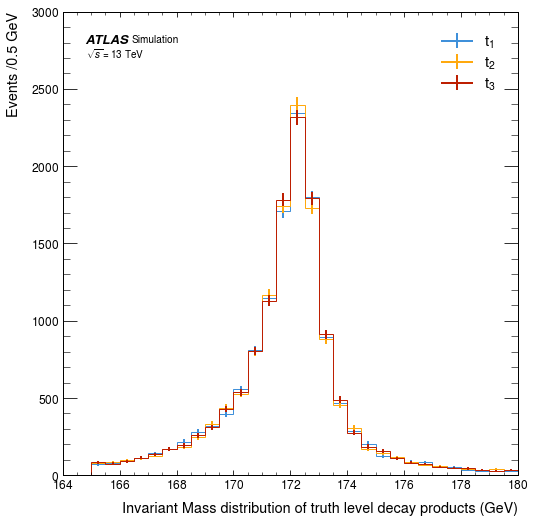

In [8]:
truth_3tj_test = truth_3tj[ak.num(truth_3tj)==10]
reco_3tj_test = reco_3tj[ak.num(truth_3tj)==10]

t1 = truth_3tj_test[:,1]+truth_3tj_test[:,4]+truth_3tj_test[:,5]
t2 = truth_3tj_test[:,2]+truth_3tj_test[:,6]+truth_3tj_test[:,7]
t3 = truth_3tj_test[:,3]+truth_3tj_test[:,8]+truth_3tj_test[:,9]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m], 30, [r't$_1$', r't$_2$', r't$_3$'], ax, density = False, x_units='GeV', set_range=(165,180))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

In [9]:
id_pairs_3tj = truth_matching(reco_3tj_test, truth_3tj_test)

jet_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==1)]
top_1_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==2)|(id_pairs_3tj['id']==5)|(id_pairs_3tj['id']==6)]
top_2_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==3)|(id_pairs_3tj['id']==7)|(id_pairs_3tj['id']==8)]
top_3_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==4)|(id_pairs_3tj['id']==9)|(id_pairs_3tj['id']==10)]

jet_3tj = jet_3tj[ak.num(jet_3tj, axis=2)!=0]
top_1_particles_3tj_temp = top_1_particles_3tj[ak.num(top_1_particles_3tj, axis=2)!=0]
top_2_particles_3tj_temp = top_2_particles_3tj[ak.num(top_2_particles_3tj, axis=2)!=0]
top_3_particles_3tj_temp = top_3_particles_3tj[ak.num(top_3_particles_3tj, axis=2)!=0]

top_1_particles_3tj = top_1_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_2_particles_3tj = top_2_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_3_particles_3tj = top_3_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]

top_1_3tj = ak.flatten(np.sum(top_1_particles_3tj, axis=1))
top_2_3tj = ak.flatten(np.sum(top_2_particles_3tj, axis=1))
top_3_3tj = ak.flatten(np.sum(top_3_particles_3tj, axis=1))


12922 669
0
0
0
1
0
2
1
3
0
13591


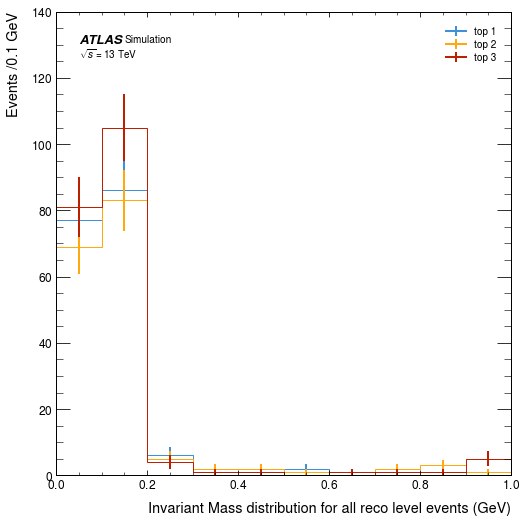

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tj.m, top_2_3tj.m, top_3_3tj.m], 10, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(0,1))
ax.set_xlabel(r'Invariant Mass distribution for all reco level events (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [11]:
tree3W = uproot.open(directory + "tttW_skim_with_truth_2810_0.root")
events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tW_neutrinos = tree3W["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tW_truth = tree3W['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tW_truth = events_3tW_truth[(events_3tW_truth['Particle.Status']==23)]

events_3tW_electrons['Electron.Mass'] = np.ones_like(events_3tW_electrons['Electron.PT']) * 0.511E-3
events_3tW_muons['Muon.Mass'] = np.ones_like(events_3tW_muons['Muon.PT']) * 105.7E-3

jets_pt_3tW = events_3tW_jets['Jet.PT'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_eta_3tW = events_3tW_jets['Jet.Eta'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_phi_3tW = events_3tW_jets['Jet.Phi'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_mass_3tW = events_3tW_jets['Jet.Mass'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]

electrons_pt_3tW = events_3tW_electrons['Electron.PT'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tW = events_3tW_electrons['Electron.Eta'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tW = events_3tW_electrons['Electron.Phi'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tW = events_3tW_electrons['Electron.Mass'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tW = events_3tW_muons['Muon.PT'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_eta_3tW = events_3tW_muons['Muon.Eta'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_phi_3tW = events_3tW_muons['Muon.Phi'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_mass_3tW = events_3tW_muons['Muon.Mass'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]

reco_pt_3tW = ak.concatenate((jets_pt_3tW,electrons_pt_3tW,muons_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jets_eta_3tW,electrons_eta_3tW,muons_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jets_phi_3tW,electrons_phi_3tW,muons_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jets_mass_3tW,electrons_mass_3tW,muons_mass_3tW), axis=1)

truth_pt_3tW = events_3tW_truth['Particle.PT']
truth_eta_3tW = events_3tW_truth['Particle.Eta']
truth_phi_3tW = events_3tW_truth['Particle.Phi']
truth_mass_3tW = events_3tW_truth['Particle.Mass']

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]
truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]

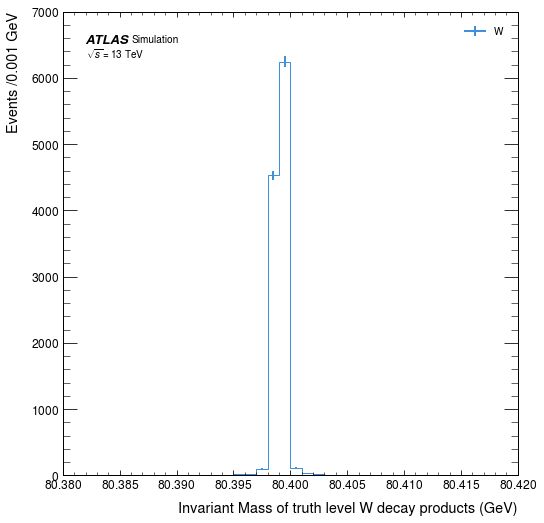

In [12]:
reco_3tW_test = reco_3tW[ak.num(truth_3tW)==11]
truth_3tW_test = truth_3tW[ak.num(truth_3tW)==11]

W_Wt_total_4 = truth_3tW_test[:,9] + truth_3tW_test[:,10]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([W_Wt_total_4.m], 40, ['W'], ax, density = False, x_units='GeV', set_range=(80.38,80.42))
ax.set_xlabel(r'Invariant Mass of truth level W decay products (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

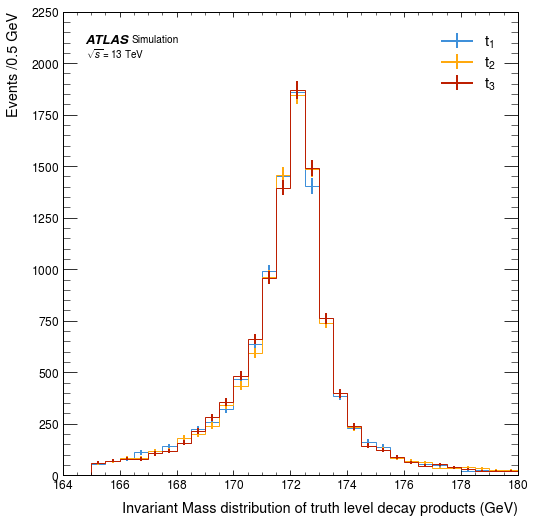

In [13]:
t1 = truth_3tW_test[:,0]+truth_3tW_test[:,3]+truth_3tW_test[:,4]
t2 = truth_3tW_test[:,1]+truth_3tW_test[:,5]+truth_3tW_test[:,6]
t3 = truth_3tW_test[:,2]+truth_3tW_test[:,7]+truth_3tW_test[:,8]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m], 30, [r't$_1$', r't$_2$', r't$_3$'], ax, density = False, x_units='GeV', set_range=(165,180))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

In [14]:
id_pairs_3tW = truth_matching(reco_3tW_test, truth_3tW_test)

top_1_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==1)|(id_pairs_3tW['id']==4)|(id_pairs_3tW['id']==5)]
top_2_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==2)|(id_pairs_3tW['id']==6)|(id_pairs_3tW['id']==7)]
top_3_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==3)|(id_pairs_3tW['id']==8)|(id_pairs_3tW['id']==9)]
W_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==10)|(id_pairs_3tW['id']==11)]

top_1_particles_3tW_temp = top_1_particles_3tW[ak.num(top_1_particles_3tW, axis=2)!=0]
top_2_particles_3tW_temp = top_2_particles_3tW[ak.num(top_2_particles_3tW, axis=2)!=0]
top_3_particles_3tW_temp = top_3_particles_3tW[ak.num(top_3_particles_3tW, axis=2)!=0]
W_3tW = W_3tW[ak.num(W_3tW, axis=2)!=0]

top_1_particles_3tW = top_1_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_2_particles_3tW = top_2_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_3_particles_3tW = top_3_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]

top_1_3tW = ak.flatten(np.sum(top_1_particles_3tW, axis=1))
top_2_3tW = ak.flatten(np.sum(top_2_particles_3tW, axis=1))
top_3_3tW = ak.flatten(np.sum(top_3_particles_3tW, axis=1))

10566 533
0
1
1
0
1
0
0
0
11099


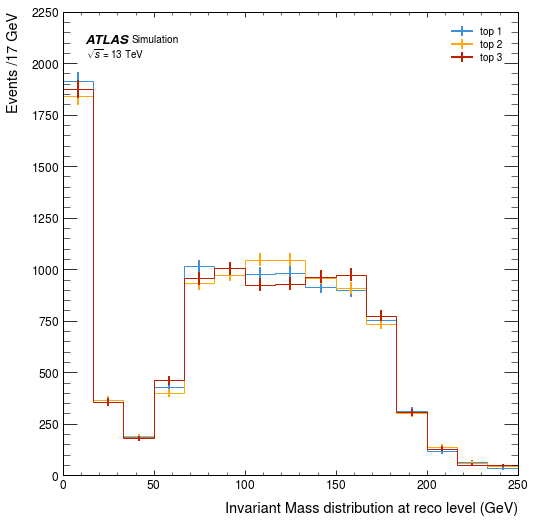

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tW.m, top_2_3tW.m, top_3_3tW.m], 15, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(0,250))
ax.set_xlabel(r'Invariant Mass distribution at reco level (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [16]:
print(len(top_1_4t.pt),len(top_2_4t.pt),len(antitop_1_4t.pt),len(antitop_2_4t.pt))

56095 56095 56095 56095


In [17]:
tops_pt_4t = np.transpose(np.vstack(((top_1_4t.pt,top_2_4t.pt,antitop_1_4t.pt,antitop_2_4t.pt))))
tops_eta_4t = np.transpose(np.vstack(((top_1_4t.eta,top_2_4t.eta,antitop_1_4t.eta,antitop_2_4t.eta))))
tops_phi_4t = np.transpose(np.vstack(((top_1_4t.phi,top_2_4t.phi,antitop_1_4t.phi,antitop_2_4t.phi))))
tops_mass_4t = np.transpose(np.vstack(((top_1_4t.m,top_2_4t.m,antitop_1_4t.m,antitop_2_4t.m))))

top_1_3t = ak.concatenate((top_1_3tj,top_1_3tW))
top_2_3t = ak.concatenate((top_2_3tj,top_2_3tW))
top_3_3t = np.concatenate((top_3_3tj,top_3_3tW))

tops_pt_3t = np.transpose(np.vstack(((top_1_3t.pt,top_2_3t.pt,top_3_3t.pt))))
tops_eta_3t = np.transpose(np.vstack(((top_1_3t.eta,top_2_3t.eta,top_3_3t.eta))))
tops_phi_3t = np.transpose(np.vstack(((top_1_3t.phi,top_2_3t.phi,top_3_3t.phi))))
tops_mass_3t = np.transpose(np.vstack(((top_1_3t.m,top_2_3t.m,top_3_3t.m))))


tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':tops_mass_4t})
tops_3t = vector.zip({'pt':tops_pt_3t,'eta':tops_eta_3t,'phi':tops_phi_3t, 'mass':tops_mass_3t})

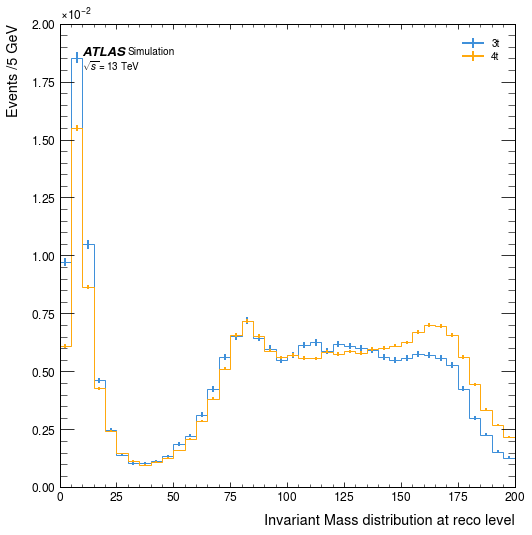

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([ak.flatten(tops_3t).m, ak.flatten(tops_4t).m], 40, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(0,200))
ax.set_xlabel(r'Invariant Mass distribution at reco level')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [19]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

## Sorting

In [20]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Calculations

In [21]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

#Total invariant mass
total_4_4t = np.sum(tops_4t, axis=1)
total_4_3t = np.sum(tops_3t, axis=1)

In [22]:
print(np.shape(tops_4t))

[56095, 4]


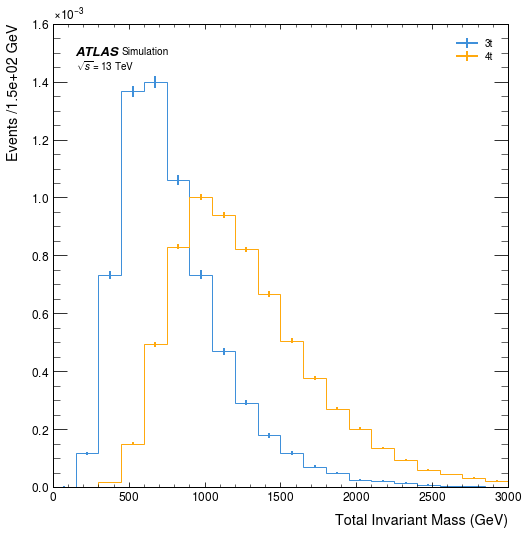

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([total_4_3t.m, total_4_4t.m], 20, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(0,3000))
ax.set_xlabel(r'Total Invariant Mass (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

## Plots

### Basic Kinematics

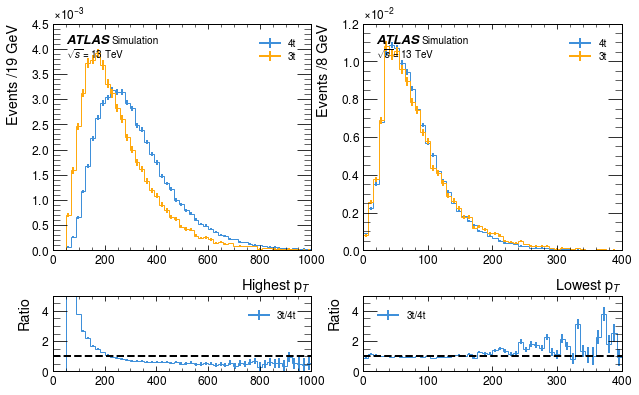

In [24]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.pt, highest_pt_3t.pt], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(50,1000))
histogram([lowest_pt_4t.pt, lowest_pt_3t.pt], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,1].set_xlabel(r'Lowest p$_T$')
plt.subplots_adjust(hspace=0.3)
plt.show()

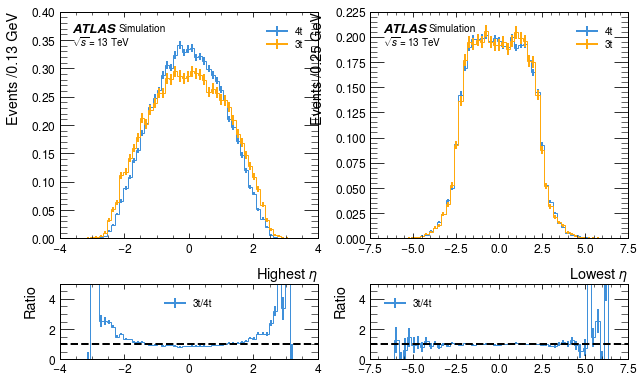

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.eta, highest_pt_3t.eta], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
histogram([lowest_pt_4t.eta, lowest_pt_3t.eta], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,0].set_xlabel(r'Highest $\eta$')
ax[0,1].set_xlabel(r'Lowest $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

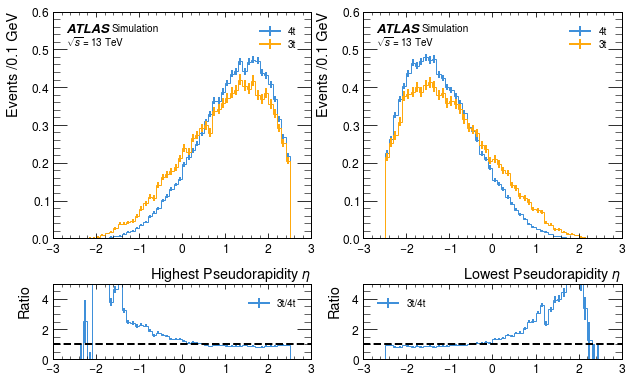

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(-2.5,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity $\eta$')
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-2.5,2.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

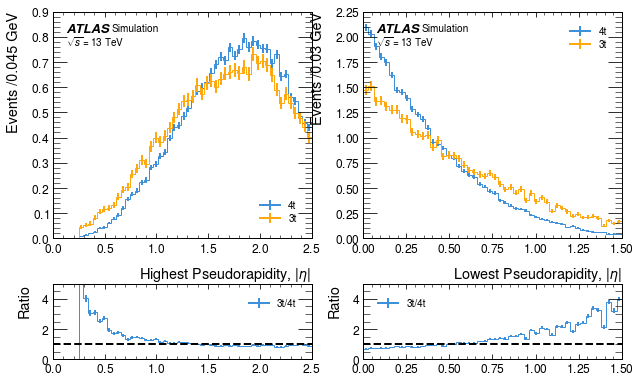

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_eta_4t.eta), np.abs(abs_highest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0.25,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity, $|\eta|$')
histogram([np.abs(abs_lowest_eta_4t.eta), np.abs(abs_lowest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,1.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity, $|\eta|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

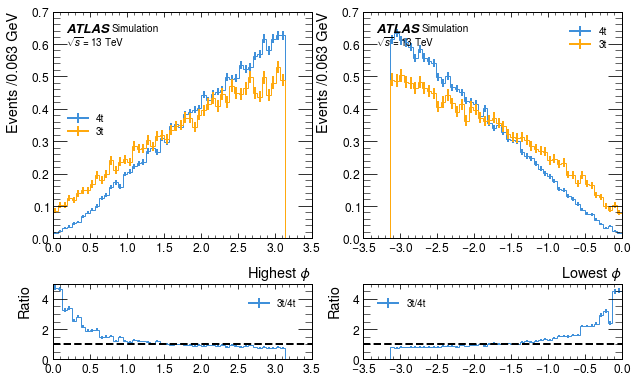

In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_phi_4t.phi, highest_phi_3t.phi], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,np.pi))
ax[0,0].set_xlabel(r'Highest $\phi$')
histogram([lowest_phi_4t.phi, lowest_phi_3t.phi], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-np.pi,0))
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.3)
plt.show()

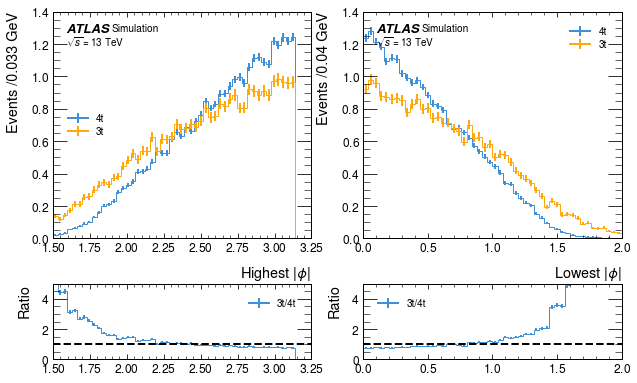

In [29]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_phi_4t.phi), np.abs(abs_highest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1.5,np.pi))
ax[0,0].set_xlabel(r'Highest $|\phi|$')
histogram([np.abs(abs_lowest_phi_4t.phi), np.abs(abs_lowest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,2))
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

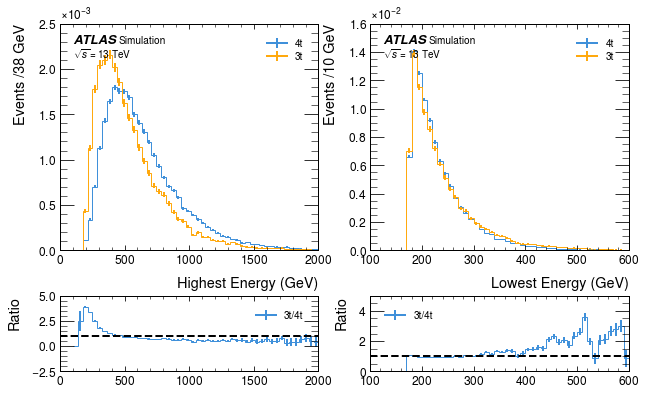

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_e_4t.E, highest_e_3t.E], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(100,2000))
ax[0,0].set_xlabel(r'Highest Energy (GeV)')
histogram([lowest_e_4t.E, lowest_e_3t.E], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(100,600))
ax[0,1].set_xlabel(r'Lowest Energy (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

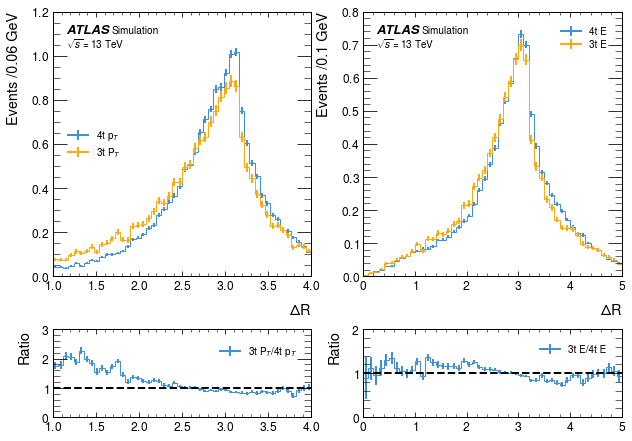

In [31]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 50, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 50, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

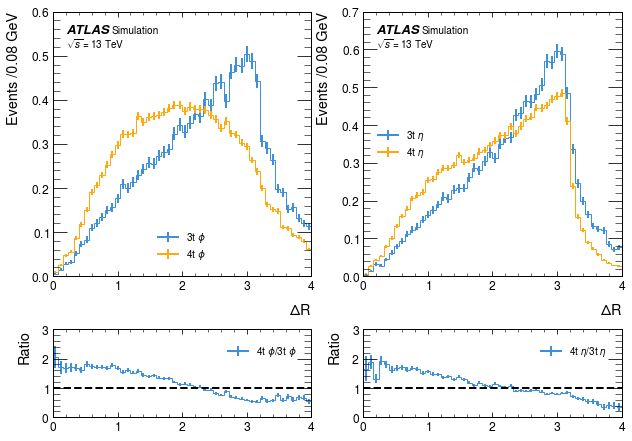

In [32]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([phi_deltaR_3t, phi_deltaR_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([eta_deltaR_3t, eta_deltaR_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

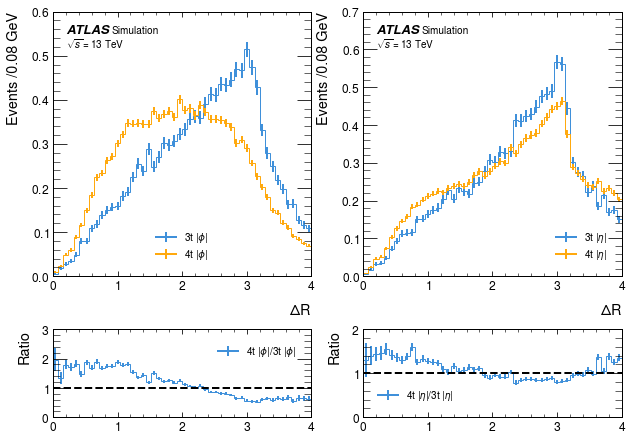

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([abs_phi_deltaR_3t, abs_phi_deltaR_4t], 50, [r'3t $|\phi|$', r'4t $|\phi|$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([abs_eta_deltaR_3t, abs_eta_deltaR_4t], 50, [r'3t $|\eta|$', r'4t $|\eta|$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

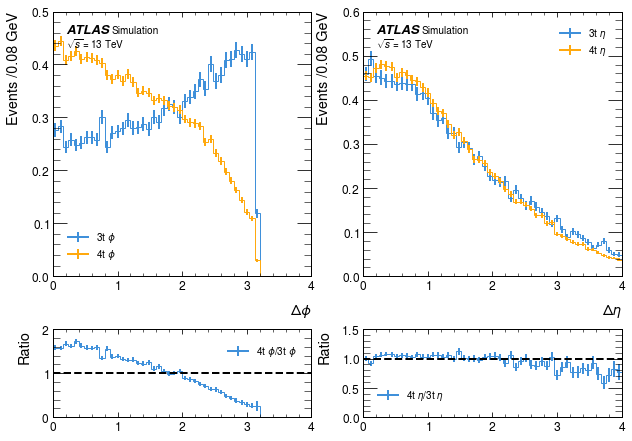

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([high_delta_phi_3t, high_delta_phi_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([high_delta_eta_3t, high_delta_eta_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

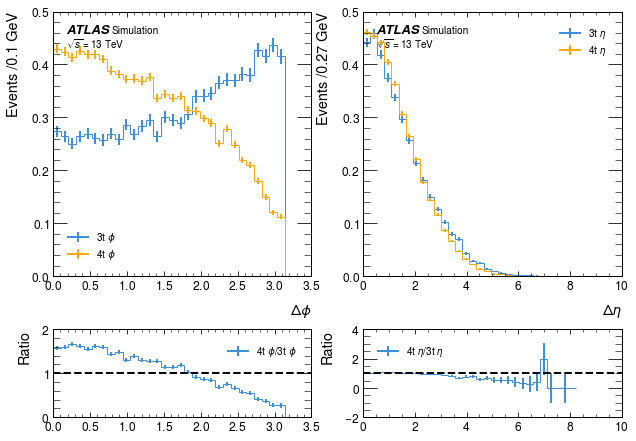

In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([low_delta_phi_3t, low_delta_phi_4t], 30, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([low_delta_eta_3t, low_delta_eta_4t], 30, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

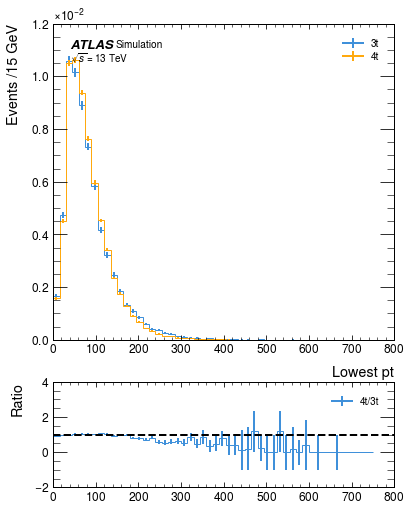

In [36]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_pt_3t.rho, lowest_pt_4t.rho], 50, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Lowest pt')
plt.show()

### High Level Partonic Analysis

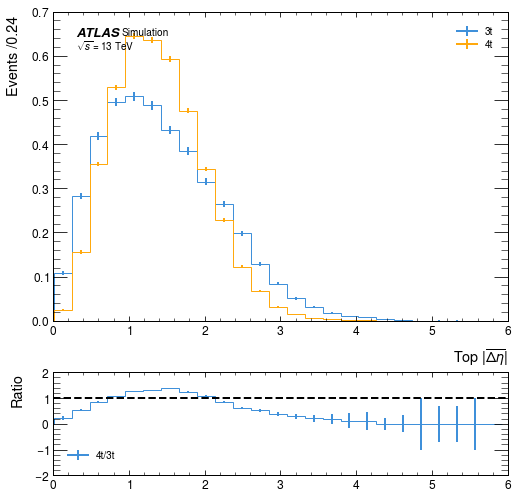

In [37]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaeta_3t,deltaeta_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

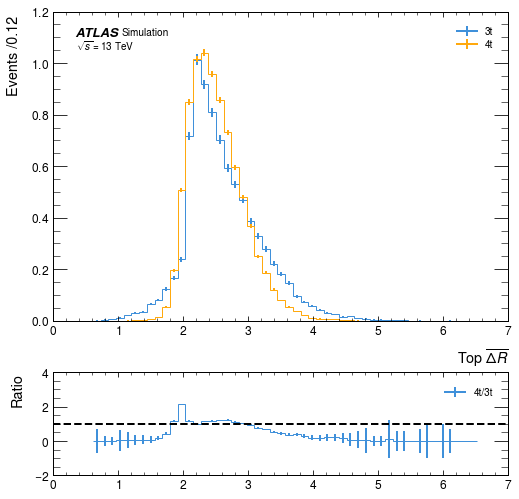

In [38]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaR_3t,deltaR_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

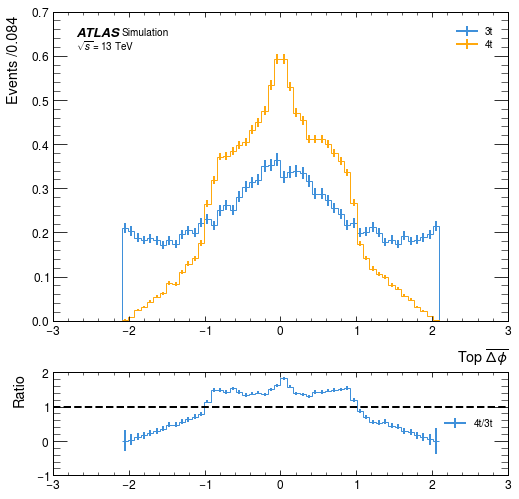

In [39]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaphi_3t,deltaphi_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta \phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

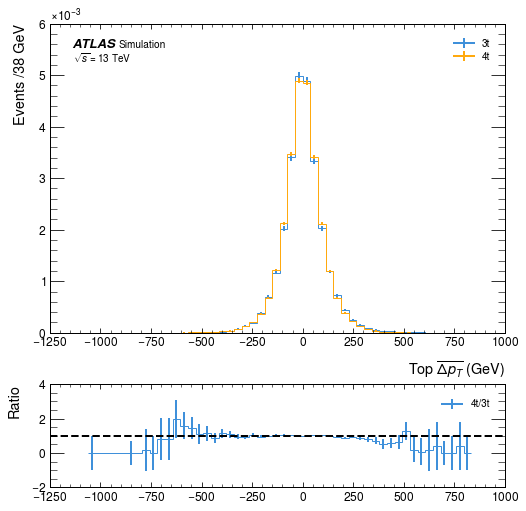

In [40]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltapt_3t,deltapt_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV')
ax[0].set_xlabel(r'Top $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

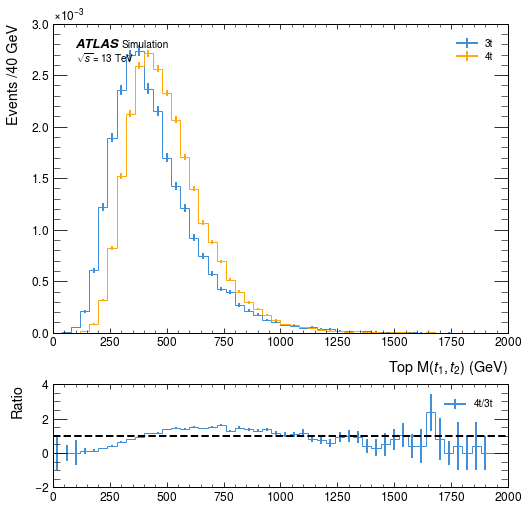

In [41]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([duo_masses_3t,duo_masses_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,2000))
ax[0].set_xlabel(r'Top M($t_1,t_2$) (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

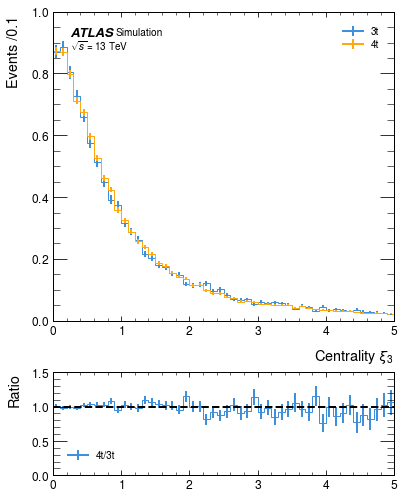

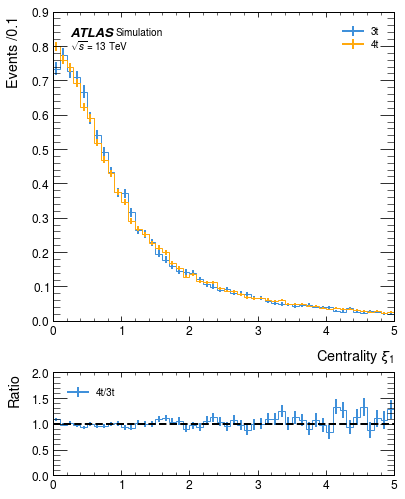

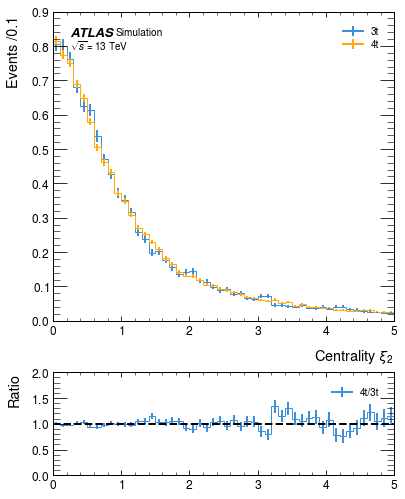

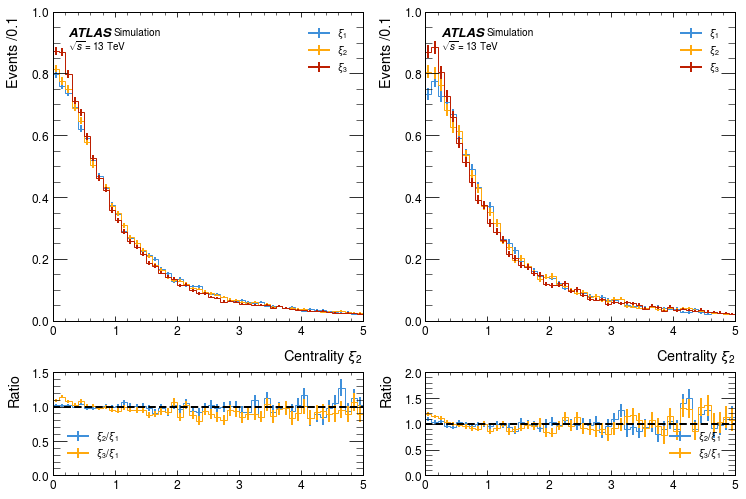

In [42]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3,1]},figsize = (6,8))
histogram([centrality_3_3t, centrality_3_4t], 50, ['3t', '4t'], ax[0], density = True, set_range=(0,5), ratio=True, ratio_axes=ax[1], x_units='')
ax[0].set_xlabel(r'Centrality $\xi_3$')
fig.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_1_3t, centrality_1_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_1$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_2_3t, centrality_2_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (12,8))
histogram([centrality_1_4t, centrality_2_4t, centrality_3_4t], 50, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,0], density = True, ratio=True, ratio_axes=ax[1,0], set_range=(0,5), x_units='')
ax[0,0].set_xlabel(r'Centrality $\xi_2$')
histogram([centrality_1_3t, centrality_2_3t, centrality_3_3t], 50, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,1], density = True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5), x_units='')
ax[0,1].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

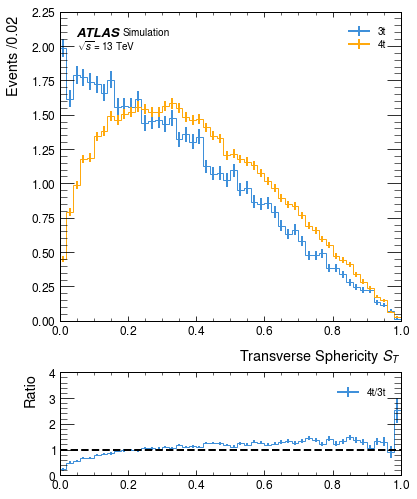

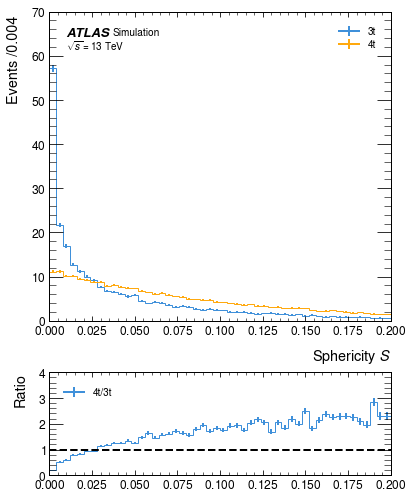

In [43]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([transverse_sphericity_3t, transverse_sphericity_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Transverse Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_3t, sphericity_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,0.2), x_units='')
ax[0].set_xlabel(r'Sphericity $S$')
plt.subplots_adjust(hspace=0.25)
plt.show()

# Possible Code for use later

In [44]:
truth_level_numbers = list(dict.fromkeys(ak.num(truth_4t_test)))

truth_4t_dict = {}
reco_4t_dict = {}

for truth_number in truth_level_numbers:
    truth_4t_dict[f'truth_particles_{truth_number}'] = truth_4t_test[ak.num(truth_4t_test)==truth_number]
    reco_4t_dict[f'truth_particles_{truth_number}'] = reco_4t_test[ak.num(truth_4t_test)==truth_number]

for key in truth_4t_dict.keys():
    truth_particles = truth_4t_dict[key]
    reco_particles = reco_4t_dict[key]
    num = ak.num(truth_particles)[0]
    pairs = ak.cartesian({'truth':truth_particles,'reco':reco_particles})
    pairs = ak.unflatten(pairs, num, axis=1)
    deltars = pairs['reco'].deltaR(pairs['truth'])
    print(np.shape(pairs['truth'][1]))
    pairs = pairs[deltars == np.min(deltars, axis=1)]
    deltars = np.min(deltars, axis=1)
    pairs = pairs[deltars<0.4]
    print('Next Key')

[13, 12]


ValueError: cannot broadcast nested list

This error occurred while calling

    numpy.equal.__call__(
        <Array [[[2.42, ..., 0.858], ...], ...] type='61640 * var * 12 * fl...'>
        <Array [[0.0646, 0.0623, ..., 0.128], ...] type='61640 * 12 * ?float32'>
    )